In [ ]:
import kagglehub

# Download latest version of dataset
path = kagglehub.dataset_download("birdy654/eeg-brainwave-dataset-feeling-emotions")

print("Path to dataset files:", path)

100%|██████████| 11.9M/11.9M [00:01<00:00, 7.62MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions/versions/1


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scipy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras as k


In [3]:
mrc_data=pd.read_csv('/root/.cache/kagglehub/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions/versions/1/emotions.csv')

print(mrc_data)

      # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  \
0          4.620      30.3    -356.0     15.60      26.3       1.070   
1         28.800      33.1      32.0     25.80      22.8       6.550   
2          8.900      29.4    -416.0     16.70      23.7      79.900   
3         14.900      31.6    -143.0     19.80      24.3      -0.584   
4         28.300      31.3      45.2     27.30      24.5      34.800   
...          ...       ...       ...       ...       ...         ...   
2127      32.400      32.2      32.2     30.80      23.4       1.640   
2128      16.300      31.3    -284.0     14.30      23.9       4.200   
2129      -0.547      28.3    -259.0     15.80      26.7       9.080   
2130      16.800      19.9    -288.0      8.34      26.0       2.460   
2131      27.000      32.0      31.8     25.00      28.9       4.990   

      mean_d_1_a  mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  \
0          0.411     -15.700       2.060        3.15  ...      

In [4]:
mrc_data.head(3)

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.07,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.0,-162.0,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.55,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.6,-31.6,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.90,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.0,-148.0,281.00,POSITIVE


In [5]:
smp_data=mrc_data.loc[:,'fft_0_a':'fft_749_a']

In [6]:
smp_data.head(3)

,fft_0_a,fft_1_a,fft_2_a,fft_3_a,fft_4_a,fft_5_a,fft_6_a,fft_7_a,fft_8_a,fft_9_a,...,fft_740_a,fft_741_a,fft_742_a,fft_743_a,fft_744_a,fft_745_a,fft_746_a,fft_747_a,fft_748_a,fft_749_a
0,-520.0,398.0,-201.0,-201.0,398.0,-52.2,121.0,-64.0,-64.0,121.0,...,179.0,26.4,-12.9,-12.9,26.4,-474.0,442.0,-222.00,-222.00,442.0
1,66.2,-4.3,43.6,43.6,-4.3,66.0,-29.0,73.3,73.3,-29.0,...,184.0,17.0,-18.9,-18.9,17.0,189.0,-19.6,-8.37,-8.37,-19.6
2,-90.8,204.0,-77.1,-77.1,204.0,-488.0,415.0,-187.0,-187.0,415.0,...,-796.0,631.0,-261.0,-261.0,631.0,-86.4,176.0,-100.00,-100.00,176.0


In [7]:
mrc_data['label'].value_counts()

,count
label,
NEUTRAL,716
NEGATIVE,708
POSITIVE,708


In [8]:
le=LabelEncoder()
mrc_data['label']=le.fit_transform(mrc_data['label'])

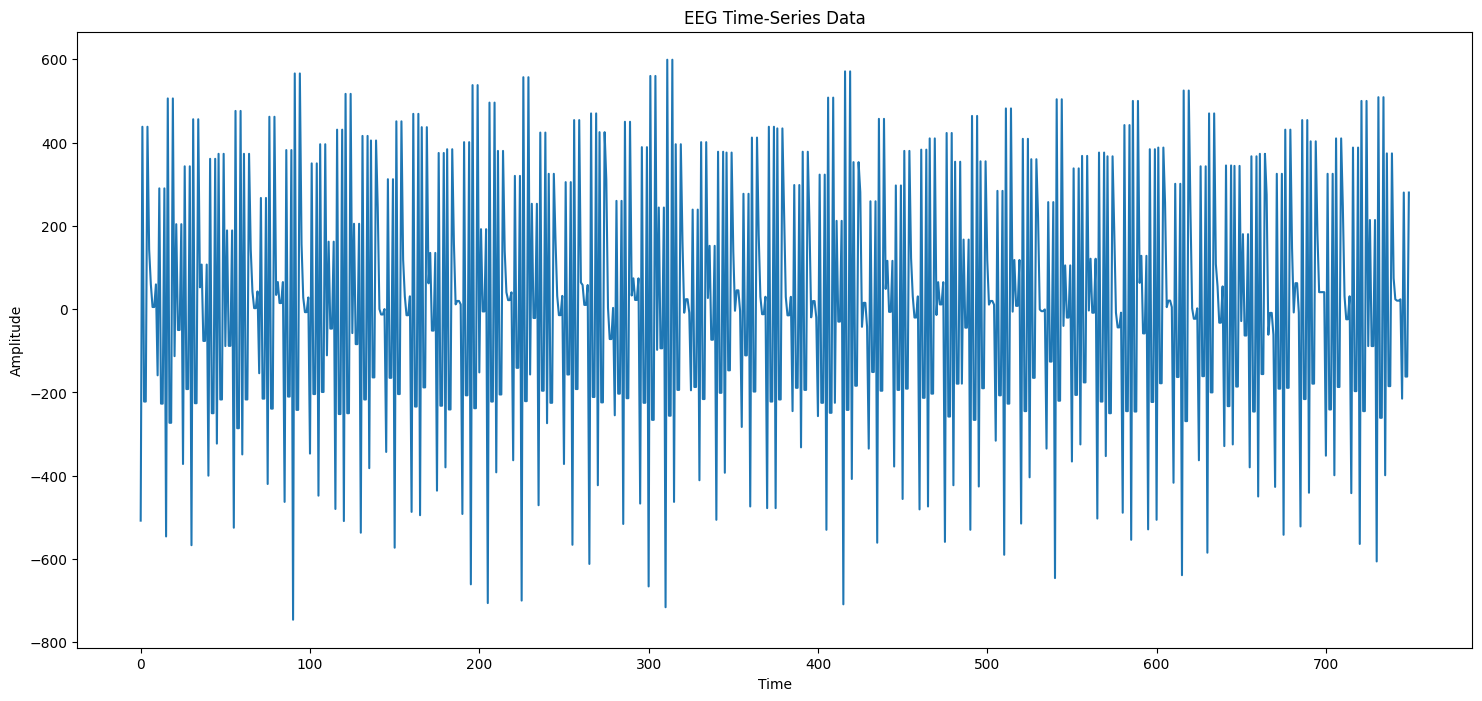

In [9]:
sample = mrc_data.loc[0, 'fft_0_b':'fft_749_b']
plt.figure(figsize=(18, 8))
plt.plot(range(len(sample)), sample)
plt.title("EEG Time-Series Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [10]:
y=mrc_data.pop('label')

X=mrc_data

X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=55)

X_train=np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))

X_test=np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train=pd.get_dummies(y_train)

y_test=pd.get_dummies(y_test)

In [11]:
from tensorflow.keras.layers import Dense, Flatten, Dropout,Activation,LSTM,ReLU,Reshape,Bidirectional,BatchNormalization,Input,concatenate,PReLU

inps=tf.keras.Input(shape=(X_train.shape[1],1))

gru=tf.keras.layers.GRU(256,return_sequences=True)(inps)

flt=Flatten()(gru)

out=Dense(3, activation='softmax')(flt)

model=tf.keras.Model(inps,out)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2548, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 2548, 256)           │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 652288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │       1,956,867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,779 (8.22 MB)

 Trainable params: 2,155,779 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow import keras

def train_model(model,X_train,  y_train,X_test,y_test, save_to, epoch=2):

        kadam=keras.optimizers.Adam(learning_rate=0.001)

        es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

        mc=ModelCheckpoint(save_to+'_best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

        LRS_Schule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:0.001*np.exp(-epoch/10.))


        model.compile(optimizer=kadam,loss=['categorical_crossentropy'],metrics=['accuracy'])

        his=model.fit(X_train,y_train,batch_size=32,epochs=epoch,validation_data=(X_test,y_test),callbacks=[es,mc,LRS_Schule])

        saved_model=load_model(save_to+'_best_model.keras')

        return model,his

In [13]:
model,his=train_model(model,X_train, y_train, X_test, y_test, save_to ='./', epoch=40)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6712 - loss: 58.5456
Epoch 1: val_accuracy improved from -inf to 0.91569, saving model to ./_best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6734 - loss: 58.0520 - val_accuracy: 0.9157 - val_loss: 5.8392 - learning_rate: 0.0010
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9391 - loss: 3.8178
Epoch 2: val_accuracy did not improve from 0.91569
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9392 - loss: 3.7968 - val_accuracy: 0.8970 - val_loss: 4.9759 - learning_rate: 9.0484e-04
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9370 - loss: 2.4094
Epoch 3: val_accuracy improved from 0.91569 to 0.95316, saving model to ./_best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9372 - loss: 2.4042 - val_accuracy: 0.9532 - val_loss: 2.6985 - learning_rate: 8.1873e-04
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9862 - los

<ipython-input-14-248d813ad3da>:11: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(['train'],'[test]',loc='upper left')


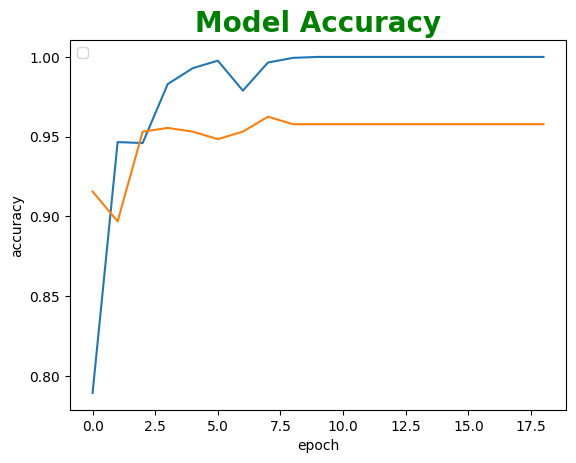

In [ ]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy',fontsize=20,fontweight='bold',color='green')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],'[test]',loc='upper left')
plt.show()

In [15]:
model_acc=model.evaluate(X_test,y_test,verbose=0)[1]

print("Test Accuracy: {:.4f} %".format(model_acc*100))

Test Accuracy: 95.7845 %


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


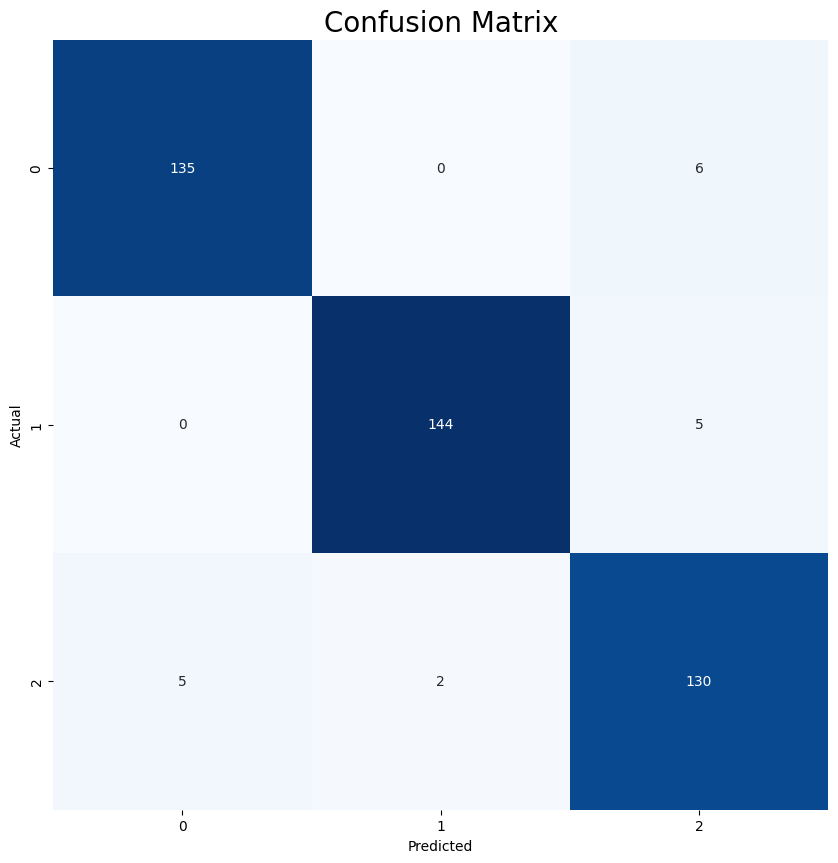

          Report of Classification 
*********************
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       141
           1       0.99      0.97      0.98       149
           2       0.92      0.95      0.94       137

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix",fontsize=20)
plt.show()

print("          Report of Classification \n*********************\n", cr)